In [41]:

"""
DC Resistivity and IP Inversion
===============================

Here we invert total magnetic intensity (TMI) data to recover a magnetic
susceptibility model. We formulate the inverse problem as an iteratively
re-weighted least-squares (IRLS) optimization problem. For this tutorial, we
focus on the following:

    - Defining the survey from xyz formatted data
    - Generating a mesh based on survey geometry
    - Including surface topography
    - Defining the inverse problem (data misfit, regularization, directives)
    - Applying sensitivity weighting
    - Setting sparse and blocky norms
    - Plotting the recovered model and data misfit

Although we consider TMI data in this tutorial, the same approach
can be used to invert other types of geophysical data.
    

"""

#########################################################################
# Import modules
# --------------
#

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG import (maps, data, data_misfit, regularization,
    optimization, inverse_problem, inversion, directives, utils
    )
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.electromagnetics.static.utils.StaticUtils import plot_pseudoSection

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

# sphinx_gallery_thumbnail_number = 4


#############################################
# Files
# ---------------------------------
#
# Here we load and plot synthetic DCIP data.
#

#topo_filename = os.path.dirname(dc.__file__) + '/../../../../tutorials/assets/dcip2d/xyz_topo.txt'
dc_data_filename = os.path.dirname(dc.__file__) + '/../../../../tutorials/assets/dcip2d/dc_data.obs'
ip_data_filename = os.path.dirname(dc.__file__) + '/../../../../tutorials/assets/dcip2d/ip_data.obs'
true_conductivity_filename = os.path.dirname(dc.__file__) + '/../../../../tutorials/assets/dcip2d/true_conductivity.txt'
true_chargeability_filename = os.path.dirname(dc.__file__) + '/../../../../tutorials/assets/dcip2d/true_chargeability.txt'


#############################################
# Load Data, Define Survey and Plot
# ---------------------------------
#
# Here we load and plot synthetic DCIP data.
#

# Load data
#topo_xyz = np.loadtxt(str(topo_filename))
#topo_xyz = topo_xyz[:, [0, 2]]
dobs_dc = np.loadtxt(str(dc_data_filename))
dobs_ip = np.loadtxt(str(ip_data_filename))

a_electrodes = dobs_dc[:, 0:2]
b_electrodes = dobs_dc[:, 2:4]
m_electrodes = dobs_dc[:, 4:6]
n_electrodes = dobs_dc[:, 6:8]
dobs_dc = dobs_dc[:, -1]
dobs_ip = dobs_ip[:, -1]


# Define survey
unique_tx, k = np.unique(np.c_[a_electrodes, b_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(a_electrodes)+1]

source_list = []
for ii in range(0, n_sources):
    
    m_locations = m_electrodes[k[ii]:k[ii+1], :]
    n_locations = n_electrodes[k[ii]:k[ii+1], :]
    receiver_list = [dc.receivers.Dipole_ky(m_locations, n_locations, data_type='volt')]
    
    a_location = a_electrodes[k[ii], :]
    b_location = b_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, a_location, b_location))

# Define survey and data
dc_survey = dc.survey.Survey_ky(source_list)
ip_survey = ip.from_dc_to_ip_survey(dc_survey, dim="2.5D")


dc_data = data.Data(dc_survey, dobs=dobs_dc)
ip_data = data.Data(ip_survey, dobs=dobs_ip)

/Users/sgkang/Projects/simpeg/SimPEG/electromagnetics/static/utils/StaticUtils.py:446: MatplotlibDeprecationWarning: 
The get_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.get_clim instead.
  cmin, cmax = cbar.get_clim()


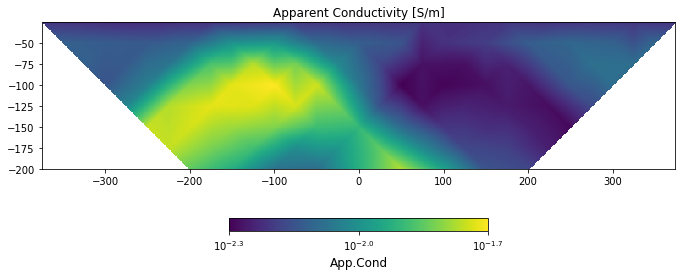

In [42]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(11, 5))

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_pseudoSection(
    dc_data, ax=ax1, survey_type='dipole-dipole',
    data_type='appConductivity', space_type='half-space', scale='log'
)
ax1.set_title('Apparent Conductivity [S/m]')

plt.show()


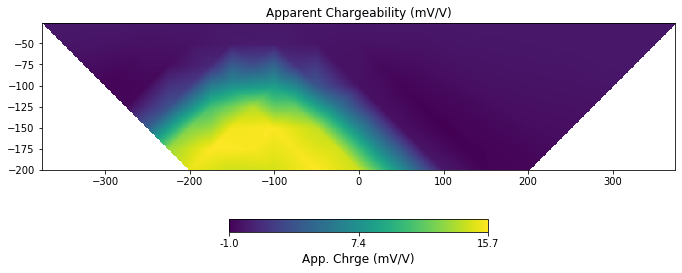

In [43]:
# Plot
fig = plt.figure(figsize=(11, 5))

ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.9])
plot_pseudoSection(
    ip_data, ax=ax1, survey_type='dipole-dipole',
    data_type='appChargeability', space_type='half-space',
    scale='linear', normalization=dobs_dc
)
ax1.set_title('Apparent Chargeability (mV/V)')

plt.show()


In [83]:
#############################################
# Assign Uncertainty
# ------------------
#

uncertainties_dc = 0.05*np.abs(dobs_dc)
#uncertainties_ip = 0.025*np.max(np.abs(dobs_ip))*np.ones(len(dobs_ip))
uncertainties_ip = 1e-3*np.abs(dobs_dc) 

dc_data.noise_floor = uncertainties_dc
ip_data.noise_floor = uncertainties_ip

In [84]:
########################################################
# Create OcTree Mesh
# ------------------
#
# Here, we create the OcTree mesh that will be used to predict both DC
# resistivity and IP data.
#

dh = 10.                                                    # base cell width
dom_width_x = 2400.                                         # domain width x                                        # domain width y
dom_width_z = 1200.                                         # domain width z
nbcx = 2**int(np.round(np.log(dom_width_x/dh)/np.log(2.)))  # num. base cells x
nbcz = 2**int(np.round(np.log(dom_width_z/dh)/np.log(2.)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0='CN')

# Mesh refinement based on topography
#mesh = refine_tree_xyz(
#    mesh, topo_xyz, octree_levels=[0, 0, 0, 0, 1], method='surface', finalize=False
#)

# Mesh refinement near transmitters and receivers
mesh = refine_tree_xyz(
    mesh, np.r_[a_electrodes, b_electrodes], octree_levels=[2, 4], method='radial', finalize=False
)

# Refine core mesh region
xp, zp = np.meshgrid([-800., 800.], [-800., 0.])
xyz = np.c_[mkvc(xp), mkvc(zp)]
mesh = refine_tree_xyz(
    mesh, xyz, octree_levels=[0, 2, 2], method='box', finalize=False
)
mesh.finalize()


/Users/sgkang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


(-800.0, 0.0)

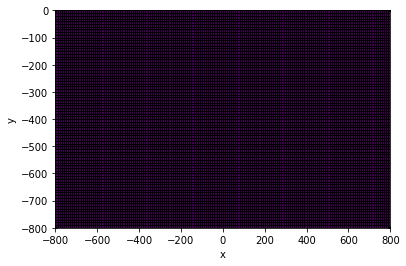

In [85]:
plt.plot(xyz[:,0], xyz[:,1], 'k.')
mesh.plotImage(np.ones(mesh.nC), grid=True)
plt.xlim(xyz[:,0].min(), xyz[:,0].max())
plt.ylim(xyz[:,1].min(), xyz[:,1].max())

In [86]:
########################################################
# Starting/Reference Model and Mapping on OcTree Mesh
# ---------------------------------------------------
#
# Here, we would create starting and/or reference models for the inversion as
# well as the mapping from the model space to the active cells. Starting and
# reference models can be a constant background value or contain a-priori
# structures. Here, the background is 1e-4 SI.
#

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)


#ind_active = surface2ind_topo(mesh, topo_xyz)
ind_active = np.ones(mesh.nC, dtype='bool')

active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

conductivity_map = active_map*maps.ExpMap()

# Define model
starting_conductivity_model = background_conductivity*np.ones(nC)

##############################################
# Define the Physics
# ------------------
#
# Here, we define the physics of the gravity problem.
# 

# Define the problem. Define the cells below topography and the mapping
dc_simulation = dc.simulation_2d.Problem2D_N(
        mesh, survey=dc_survey, sigmaMap=conductivity_map, Solver=Solver
        )

#####################################################
# Define Inverse Problem
# ----------------------
#
# Here we define the inverse problem.
#

# Define the data misfit (Here we use weighted L2-norm)
dc_data_misfit = data_misfit.L2DataMisfit(data=dc_data, simulation=dc_simulation)
dc_data_misfit.W = utils.sdiag(1./uncertainties_dc)

# Define the regularization (model objective function)
dc_regularization = regularization.Simple(
        mesh, indActive=ind_active, mref=starting_conductivity_model,
        alpha_s=1e-3, alpha_x=1, alpha_y=1
        )

# Define how the optimization problem is solved.
dc_optimization = optimization.ProjectedGNCG(
        maxIter=5, lower=-10., upper=2.,
        maxIterLS=20, maxIterCG=10, tolCG=1e-3
        )

# Here we define the inverse problem that is to be solved
dc_inverse_problem = inverse_problem.BaseInvProblem(
        dc_data_misfit, dc_regularization, dc_optimization
        )

# Here we define any directive that are carried out during the inversion
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
update_Jacobi = directives.UpdatePreconditioner()
update_sensitivity_weighting = directives.UpdateSensitivityWeights(threshold=1e-3)
target_misfit = directives.TargetMisfit(chifact=1.)

directives_list = [
        starting_beta, beta_schedule, save_iteration,
#         update_sensitivity_weighting, # neither this .. I guess 
#        update_Jacobi,  # Don't do this!!!
        target_misfit
        ]


# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(
        dc_inverse_problem, directiveList=directives_list
        )



# Run inversion
recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.16e-01  5.59e+03  0.00e+00  5.59e+03    2.13e+02      0              
   1  3.16e-01  2.30e+02  4.92e+02  3.85e+02    8.19e+01      0              
   2  6.31e-02  9.14e+01  6.83e+02  1.35e+02    3.90e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 5.5918e+02
1 : |xc-x_last| = 5.2359e+00 <= tolX*(1+|x0|) = 5.3223e+01
0 : |proj(x-g)-x|    = 3.8909e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.8909e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =       5    <= iter          =      3

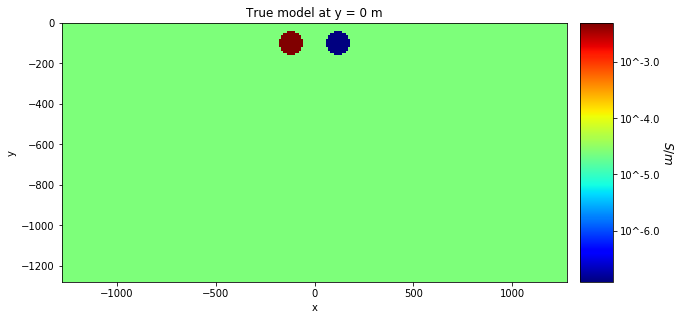

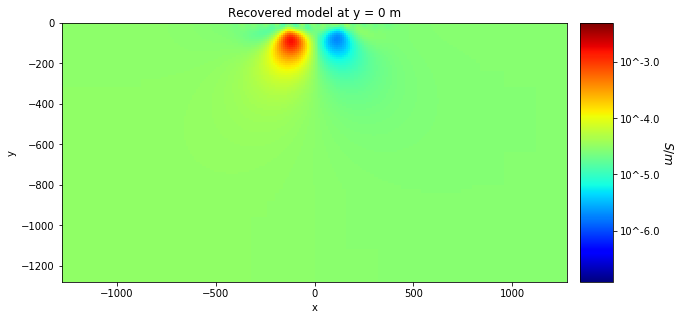

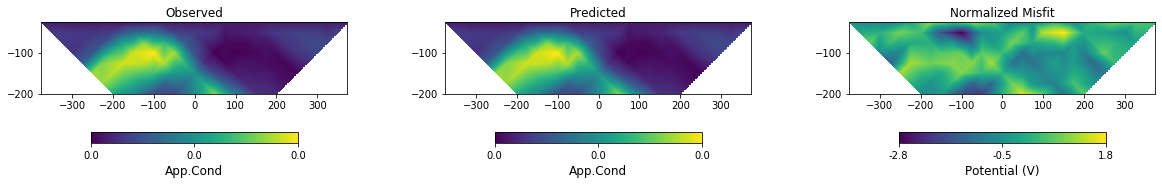

In [87]:
############################################################
# Plotting True Model and Recovered Model
# ---------------------------------------
#

true_conductivity_model = np.loadtxt(str(true_conductivity_filename))
true_conductivity_model = np.log(true_conductivity_model[ind_active])


# Plot True Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.ActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.05, 0.05, 0.78, 0.9])
mesh.plotImage(
    plotting_map*true_conductivity_model, ax=ax1, grid=False,
    clim=(np.min(true_conductivity_model), np.max(true_conductivity_model)), pcolorOpts={'cmap': 'jet'}
)
ax1.set_title('True model at y = 0 m')

ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(
        vmin=np.min(true_conductivity_model), vmax=np.max(true_conductivity_model)
        )
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation='vertical', cmap=mpl.cm.jet, format='10^%.1f'
)

cbar.set_label(
    '$S/m$',
    rotation=270, labelpad=15, size=12
)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.05, 0.05, 0.78, 0.9])
mesh.plotImage(
    plotting_map*recovered_conductivity_model, normal='Y', ax=ax1, grid=False,
    clim=(np.min(true_conductivity_model), np.max(true_conductivity_model)), pcolorOpts={'cmap': 'jet'}
)
ax1.set_title('Recovered model at y = 0 m')

ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(vmin=np.min(true_conductivity_model), vmax=np.max(true_conductivity_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation='vertical', cmap=mpl.cm.jet, format='10^%.1f'
    )
cbar.set_label('$S/m$',rotation=270, labelpad=15, size=12)

plt.show()

###################################################################
# Plotting Predicted Data and Misfit
# ----------------------------------
#

dpred_dc = dc_inverse_problem.dpred

data_array = np.c_[dobs_dc, dpred_dc, (dobs_dc-dpred_dc)/uncertainties_dc]

fig = plt.figure(figsize=(17, 4))
plot_title=['Observed', 'Predicted', 'Normalized Misfit']
plot_units=['S/m', 'S/m', '']
plot_type=['appConductivity', 'appConductivity', 'volt']
scale = ['log', 'log', 'linear']

ax1 = 3*[None]
ax2 = 3*[None]
norm = 3*[None]
cbar = 3*[None]
cplot = 3*[None]
v_lim = [np.max(np.abs(dobs_dc)), np.max(np.abs(dobs_dc)), 2]
for ii in range(0, 3):
    
    ax1[ii] = fig.add_axes([0.33*ii+0.03, 0.05, 0.25, 0.9])
    cplot[ii] = plot_pseudoSection(
            dc_data, dobs=data_array[:, ii], ax=ax1[ii], survey_type='dipole-dipole',
            data_type=plot_type[ii], space_type='half-space'
            )
    ax1[ii].set_title(plot_title[ii])

plt.show()

In [108]:
########################################################
# Starting/Reference Model and Mapping on OcTree Mesh
# ---------------------------------------------------
#
# Here, we would create starting and/or reference models for the inversion as
# well as the mapping from the model space to the active cells. Starting and
# reference models can be a constant background value or contain a-priori
# structures. Here, the background is 1e-4 SI.
#

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_chargeability = 0.
background_chargeability = 1e-3


#ind_active = surface2ind_topo(mesh, topo_xyz)
ind_active = np.ones(mesh.nC, dtype='bool')

active_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)
nC = int(ind_active.sum())

nC = int(ind_active.sum())
chargeability_map = maps.IdentityMap(nP=nC)

# Define model
starting_chargeability_model = background_chargeability*np.ones(nC)

#true_chargeability_model = np.loadtxt(str(true_chargeability_filename))
#starting_chargeability_model = 0.5*true_chargeability_model[ind_active]

##############################################
# Define the Physics
# ------------------
#
# Here, we define the physics of the gravity problem.
# 

# Define the problem. Define the cells below topography and the mapping
ip_simulation = ip.simulation_2d.Problem2D_N(
        mesh, survey=ip_survey, etaMap=chargeability_map,
        sigma=conductivity_map*recovered_conductivity_model, 
        Solver=Solver
        )

#####################################################
# Define Inverse Problem
# ----------------------
#
# Here we define the inverse problem.
#

# Define the data misfit (Here we use weighted L2-norm)
ip_data_misfit = data_misfit.L2DataMisfit(data=ip_data, simulation=ip_simulation)
ip_data_misfit.W = utils.sdiag(1./uncertainties_ip)

# Define the regularization (model objective function)
ip_regularization = regularization.Simple(
    mesh, indActive=ind_active, mapping=chargeability_map,
   mref=starting_chargeability_model*0.,
    alpha_s=1., alpha_x=1, alpha_y=1
    )

# Define how the optimization problem is solved.
ip_optimization = optimization.ProjectedGNCG(
    maxIter=10, lower=0., upper=1.,
    maxIterLS=20, maxIterCG=20, tolCG=1e-3
    )

# Here we define the inverse problem that is to be solved
ip_inverse_problem = inverse_problem.BaseInvProblem(
        ip_data_misfit, ip_regularization, ip_optimization
        )

# Here we define any directive that are carried out during the inversion
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
#update_sensitivity_weighting = directives.UpdateSensitivityWeights(threshold=1e-3)
target_misfit = directives.TargetMisfit(chifact=1)

directives_list = [
        starting_beta, beta_schedule, save_iteration,
#        update_sensitivity_weighting,
        target_misfit
        ]


# Here we combine the inverse problem and the set of directives
ip_inversion = inversion.BaseInversion(
        ip_inverse_problem, directiveList=directives_list
        )



# Run inversion
recovered_chargeability_model = ip_inversion.run(starting_chargeability_model)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.09e+01  1.71e+03  6.65e-03  1.71e+03    5.05e+01      0              
   1  2.54e+01  8.52e+01  3.56e-01  9.43e+01    4.40e+01      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.7106e+02
1 : |xc-x_last| = 1.0502e-01 <= tolX*(1+|x0|) = 1.1154e-01
0 : |proj(x-g)-x|    = 4.3924e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.3924e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      2
------------------------- DONE! -------------------------


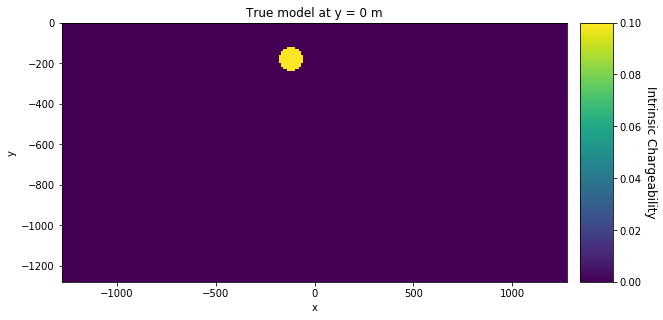

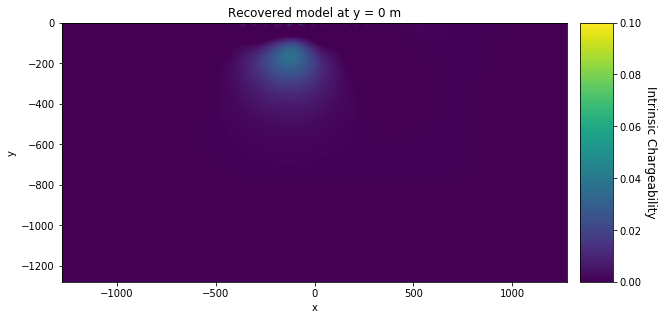

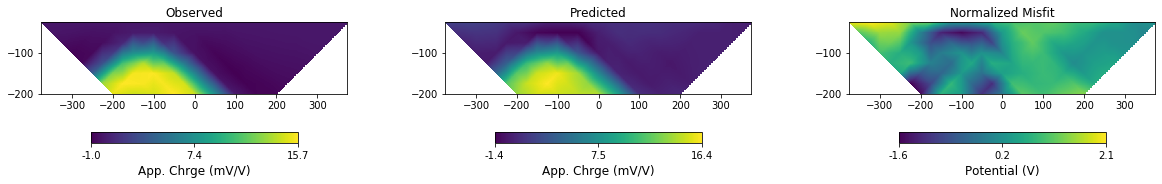

In [111]:
############################################################
# Plotting True Model and Recovered Model
# ---------------------------------------
#

true_chargeability_model = np.loadtxt(str(true_chargeability_filename))
true_chargeability_model = true_chargeability_model[ind_active]


# Plot True Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.ActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.05, 0.05, 0.78, 0.9])
mesh.plotImage(
    plotting_map*true_chargeability_model, ax=ax1, grid=False,
    clim=(np.min(true_chargeability_model), np.max(true_chargeability_model))
)
ax1.set_title('True model at y = 0 m')

ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(
        vmin=np.min(true_chargeability_model), vmax=np.max(true_chargeability_model)
        )
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation='vertical'
)

cbar.set_label(
    'Intrinsic Chargeability',
    rotation=270, labelpad=15, size=12
)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.05, 0.05, 0.78, 0.9])
mesh.plotImage(
    plotting_map*recovered_chargeability_model, normal='Y', ax=ax1, grid=False,
    clim=(np.min(true_chargeability_model), np.max(true_chargeability_model))
)
ax1.set_title('Recovered model at y = 0 m')

ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(
        vmin=np.min(true_chargeability_model), vmax=np.max(true_chargeability_model)
        )
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation='vertical'
    )
cbar.set_label('Intrinsic Chargeability',rotation=270, labelpad=15, size=12)

plt.show()

###################################################################
# Plotting Predicted Data and Misfit
# ----------------------------------
#

dpred_ip = ip_inverse_problem.dpred

data_array = np.c_[dobs_ip, dpred_ip, (dobs_ip-dpred_ip)/uncertainties_ip]
#data_array = np.c_[dobs_ip, ip_simulation.dpred(true_chargeability_model), (dobs_ip-dpred_ip)/uncertainties_ip]

fig = plt.figure(figsize=(17, 4))
plot_title=['Observed', 'Predicted', 'Normalized Misfit']
plot_units=['mV/V', 'mV/V', '']
plot_type=['appChargeability', 'appChargeability', 'volt']
scale = ['linear', 'linear', 'linear']
normalization = [dobs_dc, dobs_dc, 1.]

ax1 = 3*[None]
ax2 = 3*[None]
norm = 3*[None]
cbar = 3*[None]
cplot = 3*[None]
v_lim = [np.max(np.abs(dobs_ip)), np.max(np.abs(dobs_ip)), 2]
for ii in range(0, 3):
    
    ax1[ii] = fig.add_axes([0.33*ii+0.03, 0.05, 0.25, 0.9])
    cplot[ii] = plot_pseudoSection(
            ip_data, dobs=data_array[:, ii], ax=ax1[ii], survey_type='dipole-dipole',
            data_type=plot_type[ii], space_type='half-space', normalization=normalization[ii]
            )
    ax1[ii].set_title(plot_title[ii])

plt.show()